In [1]:
## package imports ##
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
sys.path.append("../../src")
import utils.preprocessing_utils as process
import utils.munging_utils as query
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats
from pymatch.Matcher import Matcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

Welcome, aryton tediarjo!



In [29]:
## helper functions ## 
def annot_phone(params):
    """
    Function to annotate phone types
    returns an annotated dataset with lesser choice of phonetypes
    """
    if ";" in params:
        params = params.split(";")[0]
    if ("iPhone 6+" in params) or ("iPhone 6 Plus" in params):
        return "iPhone 6+"
    if ("iPhone9" in params) or ("Unknown" in params) or ("iPad" in params) :
        return "Other iPhone"
    if ("iPhone 5" in params):
        return "iPhone 5"
    if ("iPhone8" in params):
        return "iPhone 8"
    if ("iPhone X" in params):
        return "iPhone X"
    return params


    

def show_distribution(data, target):
    """
    Function to plot several metadata information accross version 
    """
    data = data[data["version"] != "ems_active"]
    
    dataV1 = data[data["version"] == "mpower_v1"]
    dataV2 = data[data["version"] == "mpower_v2"]

    fig, axes = plt.subplots(nrows = 1, ncols = 3)

    sns.distplot(dataV2["age"].dropna(), label = "V2", ax = axes[0])
    sns.distplot(dataV1["age"].dropna(), label = "V1", ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Age distribution of V1 and V2")
    axes[0].grid()
    axes[0].figure.set_size_inches(15,5)

    sns.countplot(data["PD"], hue = data["version"], ax = axes[1])
    axes[1].legend()
    axes[1].set_title("PD distribution of V1 and V2")
    axes[1].grid()
    axes[1].figure.set_size_inches(15,5)
    
    sns.countplot(data["gender"], hue = data["version"], ax = axes[2])
    axes[2].legend()
    axes[2].set_title("gender distribution of V1 and V2")
    axes[2].grid()
    axes[2].figure.set_size_inches(15,5)
    

     
    
def PCA_plotter(data, feat_cols, 
                metadata_cols, target):
    
    """
    Function to implement PCA with 2 components, 
    then separate them with a target hue variable to see differences

    returns PCA-1 vs PCA-2 plots of metadata and walking features 
    separated by its groups (PD, version)
    """   
    scaler = StandardScaler()
    X_feat = data[feat_cols]
    X_metadata = data[metadata_cols]
    y = data[["version", "healthCode", "PD"]]
    
    lr = LogisticRegression(random_state = 100)
    gb = GradientBoostingClassifier(random_state = 100)
    X_train, X_test, y_train, y_test = train_test_split(X_feat, y[target],
                                                        test_size = 0.2,
                                                        random_state = 100)
    
    gb.fit(X_train, y_train)
    
    print("#################### ASSESSMENT ON %s ################\n" %target)
    print(classification_report(gb.predict(X_test), y_test))
    
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_feat)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[0])
    axes[0].set_title("PCA plot on Walking Features")
    axes[0].set_ylabel("PC2")
    axes[0].set_xlabel("PC1")
    axes[0].grid()
    
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_metadata)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[1])
    axes[1].set_title("PCA plot on metadata")
    axes[1].set_ylabel("PC2")
    axes[1].set_xlabel("PC1")
    axes[1].grid()
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.show()
    

def OHE_data(data):
    """
    Function to one-hot encode the metadata
    it will encode factorial and categorical variables (phonetype, gender and versions)
    returns the encoded dataset, and the result of the encoded columns
    """
    metadata_df = data
    metadata_cols = [feat for feat in metadata_df.columns if ("." not in feat) and ("healthCode" not in feat)]
    # metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"])], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["phone_type"], 
                                                         prefix = "OHE_is")], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["gender"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    OHE_meta_cols = [feat for feat in metadata_df.columns if ("OHE" in feat) or ("age" in feat) or ("PD" in feat)]
    return metadata_df, OHE_meta_cols




def balance_hc(data, matching_columns):
    
    """
    Function to create paired healthcodes
    takes in a dataset of PDKIT features

    matching methods:
    Join version 1 and version 2 table by leveraging phone types and gender
    Iterate through each healthcode pairs, and prioritize healthcode pairs that have smaller age differences

    Note: Not joining by PD status due to the non-PD data being discarded significantly

    """
    
    
    ref = pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")
    list_of_spans = ref.loc[(ref["mpower_v1"] > 0) & (ref["mpower_v2"] > 0)].index
    data = data[data["phone_type"].isin(list_of_spans)].reset_index(drop = True)
    
    
    hcx_used = []
    hcy_used = []

    V1 = data[data["version"] == "mpower_v1"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    V2 = data[data["version"] == "mpower_v2"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    tst_data = pd.merge(V1, V2, on = matching_columns, how = "inner")
    tst_data["age_diff"] = np.abs(tst_data["age_x"] - tst_data["age_y"])
    tst_data = tst_data.sort_values("age_diff").reset_index(drop = True)


    for hc_x, hc_y in zip(tst_data["healthCode_x"], tst_data["healthCode_y"]):

        if (hc_y not in hcy_used) and (hc_x not in hcx_used):
            hcy_used.append(hc_y)
            hcx_used.append(hc_x)

    lst = hcx_used + hcy_used
    return data[data["healthCode"].isin(lst)]



def getKNN_user2user(data, no_neighbors, 
                     distance_metrics, 
                     cols_used):
    
    """
    a function to get K-Nearest Neighbor from user in version 1 to version 2

    ##  pseudocode  ##
    for each healthcode in user 1, find K other pair that is similar in "insert here" similarity metrics
    afterwards, filter the data to only pair the healthcode in version 1 to those in version 2
    then collect all the unique healthcodes that is left after the filter
    """
    data_v1 = data[data["version"] == "mpower_v1"]
    data_v2 = data[data["version"] == "mpower_v2"]
    data = data.set_index("healthCode")
    min_max_scaler = MinMaxScaler()
    walking_features = min_max_scaler.fit_transform(data[cols_used])
    nbrs = NearestNeighbors(n_neighbors = no_neighbors, 
                            algorithm = 'auto', 
                            metric = distance_metrics).fit(walking_features)
    distance, indices = nbrs.kneighbors(walking_features)
    _dict = {}
    _dict["healthCode_ref"] = []
    _dict["healthCode_pair"] = []
    _dict["distance"] = []
    data = data.reset_index()
    for dist, indice in zip(distance, indices):
        for healthcode_idx, _dist in zip(indice[1:], dist[1:]):
            _dict["healthCode_ref"].append(data.ix[indice[0]]["healthCode"])
            _dict["distance"].append(_dist)
            _dict["healthCode_pair"].append(data.ix[healthcode_idx]["healthCode"])
    matches = pd.DataFrame(_dict).sort_values(by = "distance", ascending = False)
    v2_list = data[data["version"] == "mpower_v2"]["healthCode"].unique()
    matches = matches[(~matches["healthCode_ref"].isin(v2_list)) \
        & (matches["healthCode_pair"].isin(v2_list))]
    matched_data = data[(data["healthCode"].isin(matches["healthCode_ref"].unique())) \
                | (data["healthCode"].isin(matches["healthCode_pair"].unique()))].reset_index(drop = True)
    return matched_data


def QaD_correlation(values, classes, isFactor=None):
    """Given a set of values or class assignments determines correlation/enrichment 
    in list of classificiations.
    Uses, correlation or fisher tests
    
    Arguments:
    - `values`:  Vector of values (either numeric or factors)
    - `classes`:  a two dimensional array or pandas DataFrame of (either numeric or factors)
    - `isFactor`: list of same length as classes of T/F indicating weather each 
                  class is a factor or continuous variable (defaults to None) meaning
                  strings are used factors and numbers as continuous
    Returns a list of p-values one for each classification in classes
    """

    isFactor = [None]*len(classes) if isFactor==None else isFactor
    pVals = []
    classes = pd.DataFrame(classes)
    for i, key in enumerate(classes):
        classification = classes[key]
        #If it is a factor perform ANOVA across groups
        if ((classification.dtype in [np.string_,  np.object_, np.bool_, np.unicode_]) or 
            isFactor[i]):
            groupLabels = list(set(classification.dropna()))
            groups = [values[np.where(classification==l)] for l in groupLabels]
            f_val, p_val = stats.f_oneway(*groups) 
            #if np.isnan(p_val):
            #    print groupLabels
            pVals.append(p_val)
            #print list(set(classification)), p_val
        #If it is not a factor perform correlation analysis
        else:
            m, b, r_val, p_val, slope_std_error = stats.linregress(values, classification)
            pVals.append(p_val)
    pVals = np.asarray(pVals)
    pVals[np.isnan(pVals)] = np.inf
    series = pd.Series(data = pVals, index = classes.columns)
    return series

# Introduction:

This notebook will explore preliminary techniques to reduce confounding effects of the metadata.
To compare metadata, some additional approaches will be taken, such as:

1. One hot encoding of the phone types, version and gender 
2. Age distribution of the version 2 and passive data will be set to have same the lowest values as the lowest values from version 1, for sustaining the same distribution

Afterwards, several matching of cases (by combination of metadata matchings) will be analyzed to see whether the confounding effects can be curated
1. phone type matching to subject in version 1 and those in version 2
2. phone type and gender matching 
3. phone type and PD matching
4. phone type, PD and gender matching
5. by feature similarity

Visualized PCA of PC1 vs PC2 of walking features and metadata will be assessed to see if there is still any separations between two versions. A simple baseline classifier (gradient boosting) will be implemented to see whether the model can actually predict the versions of the mobile app, which is a good benchmark towards knowing whether there are still confounding effects sourced from the metadata.

In [41]:
data = query.get_file_entity("syn21281633")
healthcode_list_v1 = query.get_file_entity("syn8381056").index

In [42]:
dataV1 = data[data["healthCode"].isin(healthcode_list_v1)].reset_index(drop = True)
dataV2 = data[data["version"] == "mpower_v2"]
dataV2 = dataV2[dataV2["age"] >= dataV1["age"].min()].reset_index(drop = True)
# dataEMS = data[data["version"] == "ems_active"]
# dataEMS = dataEMS[dataEMS["age"] >= dataV1["age"].min()].reset_index(drop = True)

In [45]:
## concatenate dataset and annotate iphone type ## 
data = pd.concat([dataV1, dataV2]).reset_index(drop = True)
data = process.addFeatures().transform(data)
data = process.collapseFeatures(aggregation_type = "max").transform(data)
data["phone_type"] = data["phoneInfo"].apply(annot_phone)

### Type of phones that span accross versions 

In [46]:
pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")

version,mpower_v1,mpower_v2
phone_type,,
Other iPhone,2.0,26.0
iPhone 5,47.0,8.0
iPhone 6,89.0,34.0
iPhone 6+,48.0,12.0
iPhone 6S,NaN,26.0
iPhone 6S+,NaN,12.0
iPhone 7,NaN,39.0
iPhone 7+,NaN,25.0
iPhone 8,4.0,34.0


### Type of phones and PD subject that span accross versions 

In [48]:
pd.pivot_table(data    = data, 
               index   = "phone_type", 
               columns = ["version", "PD"], 
               values  = "healthCode", 
               aggfunc = "count")

version      mpower_v1       mpower_v2      
PD                 0.0   1.0       0.0   1.0
phone_type                                  
Other iPhone       NaN   2.0       5.0  21.0
iPhone 5          23.0  24.0       NaN   8.0
iPhone 6          44.0  45.0       3.0  31.0
iPhone 6+         27.0  21.0       NaN  12.0
iPhone 6S          NaN   NaN       3.0  23.0
iPhone 6S+         NaN   NaN       NaN  12.0
iPhone 7           NaN   NaN       7.0  32.0
iPhone 7+          NaN   NaN       3.0  22.0
iPhone 8           NaN   4.0       2.0  32.0
iPhone 8+          NaN   NaN       NaN  14.0
iPhone SE          NaN   NaN       NaN  15.0
iPhone X           NaN   NaN       4.0  24.0

From the tabular dataframe above, we can see that there are only several phones that spans accross the two versions. Especially when broken down further to matching by their PDs status, there will be an issue where we will not get enough controls as most of the controls are not recruited to the version two studies (yet)

# Visualization & Intepretation

### 1.) Pre-matching Dataset (default)

In [49]:
## get encoded data
encoded_data = OHE_data(data)[0]

## column feature lists
walking_feat_cols = [feat for feat in data.columns if "." in feat]
metadata_feat_cols = [feat for feat in data.columns if ("." not in feat) and ("healthCode" not in feat)]
OHE_feat_cols = OHE_data(data)[1]

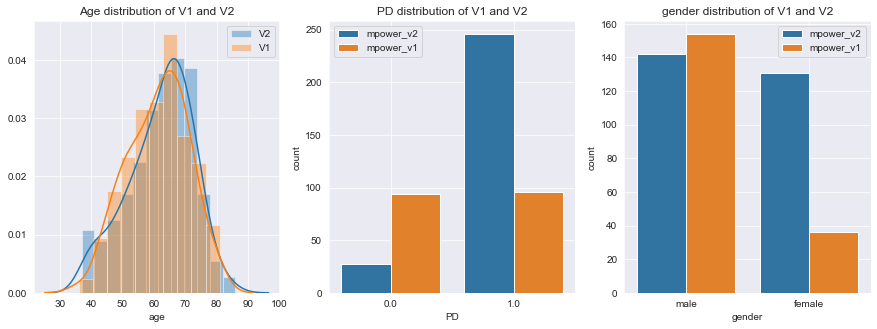

In [50]:
show_distribution(encoded_data[metadata_feat_cols], "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       1.00      1.00      1.00        40
   mpower_v2       1.00      1.00      1.00        53

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



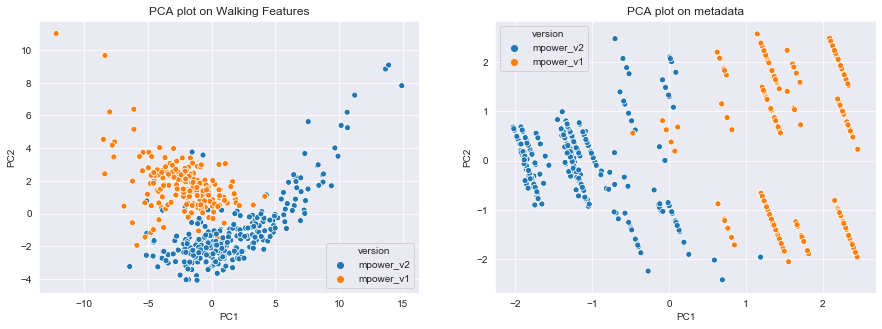

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.57      0.46      0.51        26
         1.0       0.81      0.87      0.83        67

    accuracy                           0.75        93
   macro avg       0.69      0.66      0.67        93
weighted avg       0.74      0.75      0.74        93



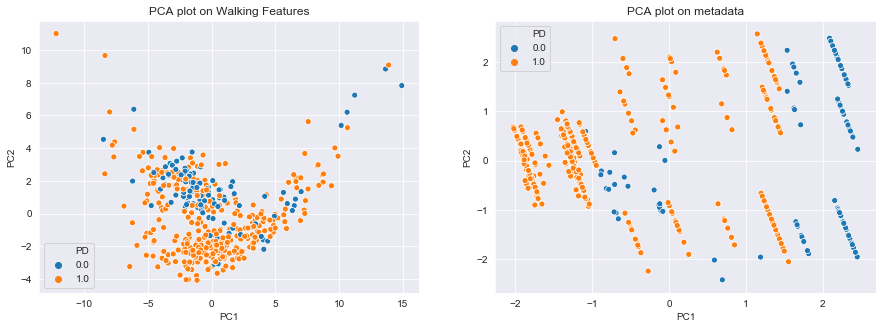

In [51]:
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "PD")

The prematching plot shows that there are a very large separation accross the versions, which means that there might be some signals on the metadata. As seen from how a simple GradientBoosting can classify the versions, it is imperative to subsample our dataset so that our metadata will confound the predictive capability of the walking features that will be implemented.

### 2.) Matched Dataset by Phone Types

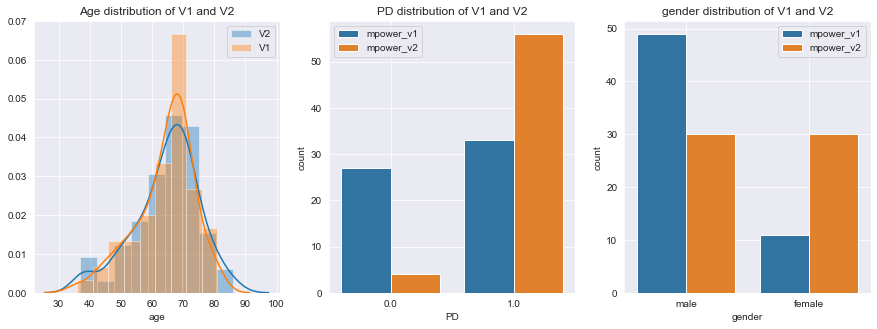

In [52]:
balance_hc_data = balance_hc(encoded_data, ["phone_type"]).reset_index(drop = True)
show_distribution(balance_hc_data[metadata_feat_cols], "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.92      1.00      0.96        11
   mpower_v2       1.00      0.92      0.96        13

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



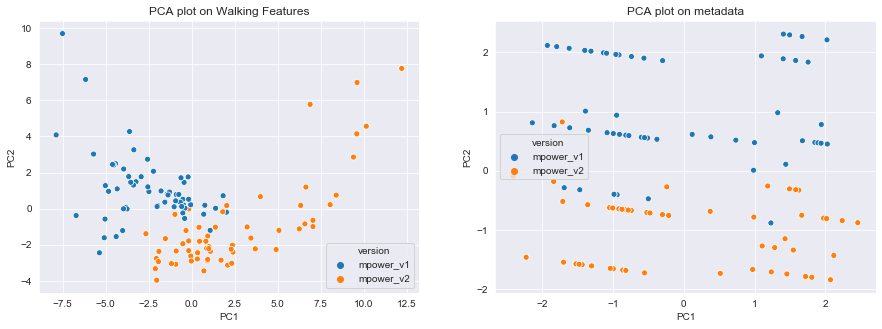

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57         7
         1.0       0.82      0.82      0.82        17

    accuracy                           0.75        24
   macro avg       0.70      0.70      0.70        24
weighted avg       0.75      0.75      0.75        24



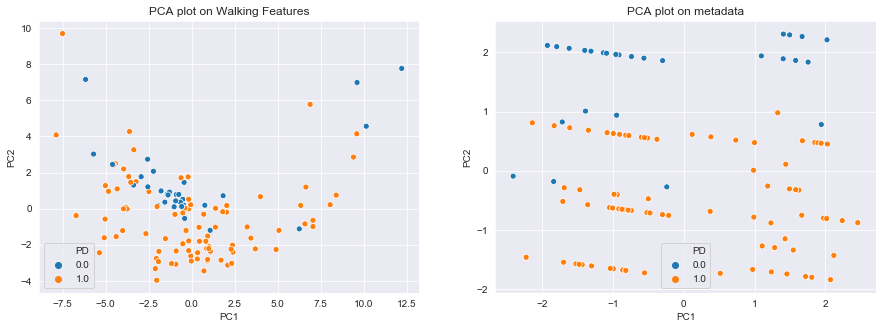

In [53]:
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "PD")

By matching using spanning phone types, gender, and closest age differences, we can see that PCs are more evenly spread accross version 1 and version 2, however still slightly separable as most of the version 1 is on the upper area of the plot. In terms of its walking features, it is apparent that version 1 and version 2 is still linearly separable from each other. 

The reason why most of the V1s are lying on top is due to the uneven distribution of non-PD in our data collections, especially as most of the V1 has far more Non-PD data.

## 3a.) Matched Dataset by Phone Types, Gender, and PD

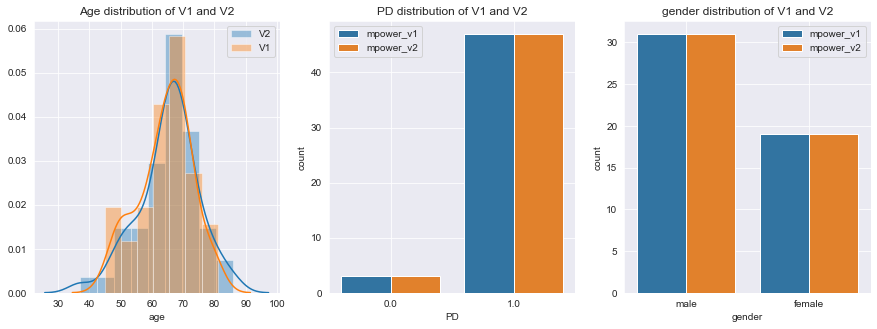

In [54]:
balance_hc_data = balance_hc(encoded_data, ["phone_type", "PD", "gender"]).reset_index(drop = True)
show_distribution(balance_hc_data[metadata_feat_cols], "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.91      0.91      0.91        11
   mpower_v2       0.89      0.89      0.89         9

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



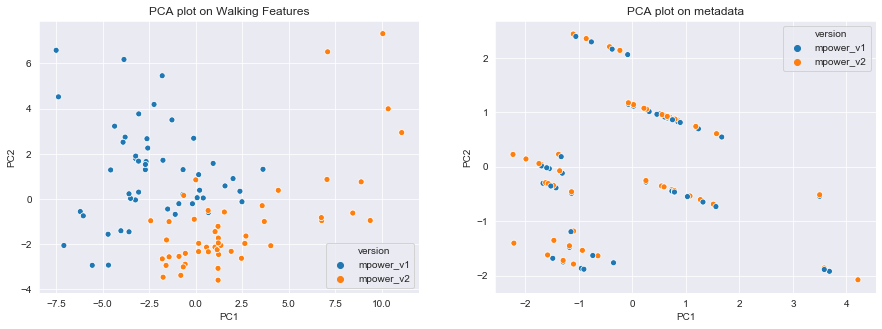

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.95      0.97        20

    accuracy                           0.95        20
   macro avg       0.50      0.47      0.49        20
weighted avg       1.00      0.95      0.97        20



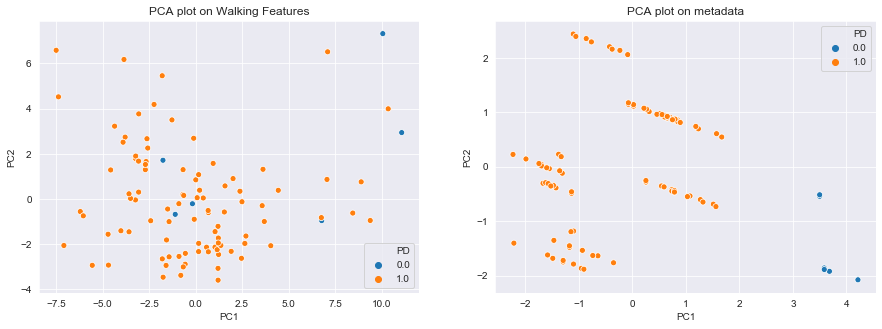

In [55]:
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "PD")

### 4.) Use Similarity Metrics on Features

In [15]:
matched_data = getKNN_user2user(data, 10, "euclidean", walking_feat_cols)
matched_data_encoded = OHE_data(matched_data)[0]
OHE_feat_cols = OHE_data(matched_data)[1]

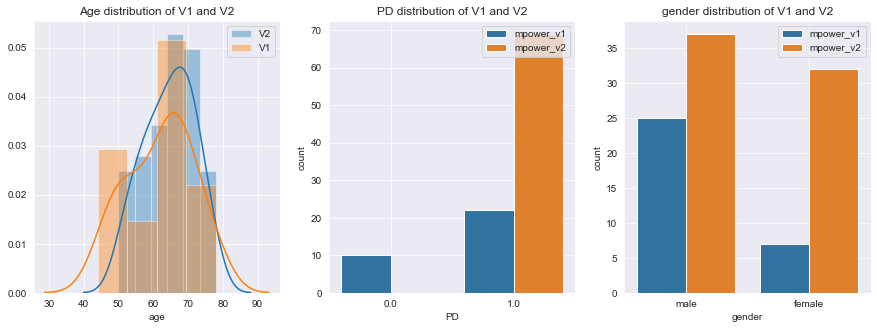

In [16]:
show_distribution(matched_data_encoded, "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.67      0.80      0.73         5
   mpower_v2       0.93      0.88      0.90        16

    accuracy                           0.86        21
   macro avg       0.80      0.84      0.82        21
weighted avg       0.87      0.86      0.86        21



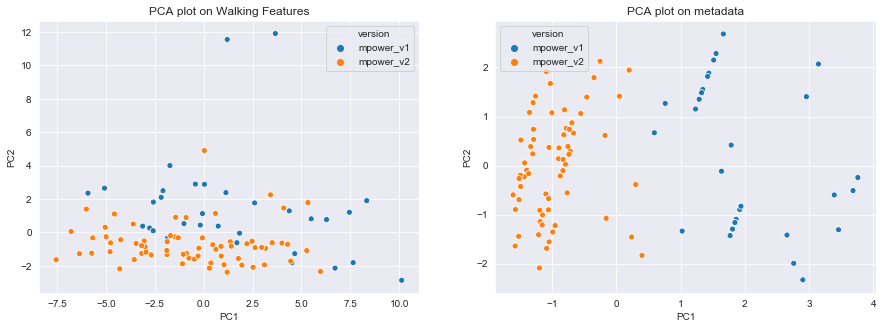

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.33      0.50      0.40         2
         1.0       0.94      0.89      0.92        19

    accuracy                           0.86        21
   macro avg       0.64      0.70      0.66        21
weighted avg       0.89      0.86      0.87        21



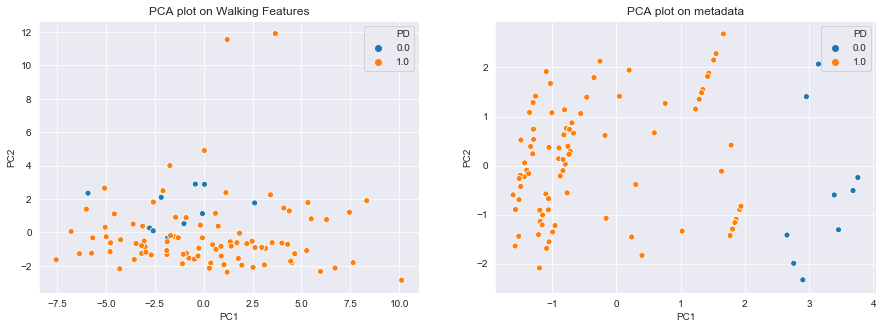

In [17]:
PCA_plotter(matched_data_encoded, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(matched_data_encoded, walking_feat_cols, OHE_feat_cols, "PD")

# Metadata Associations

This section will see whether each metadata still has association towards other metadatas, we will test the subgroups of whether the subject is_male, is_v2, is_PD 
against each of the metadata. The ideal case is to have large p-value (>0.05), meaning that the metadata association is almost nonexistent to all the other metadata. However if p-value is extremely low we will assume that there are some associations on the metadata that will confound our predictive results. 

## One-Way Anova Association on Metadata

In [18]:
def print_pvals_ftest(data, group):
    metadata_df = OHE_data(data)[0]
    OHE_cols = OHE_data(data)[1]
    return QaD_correlation(metadata_df[group], metadata_df[OHE_cols])

## 1.) Before Matching

In [19]:
print("### Gender ####")
print_pvals_ftest(data, "OHE_is_male")

### Gender ####


PD                     3.668992e-02
age                    6.018043e-01
OHE_is_Other iPhone    5.732836e-01
OHE_is_iPhone 5        5.621394e-02
OHE_is_iPhone 6        2.530957e-02
OHE_is_iPhone 6+       4.766582e-02
OHE_is_iPhone 6S       5.019129e-03
OHE_is_iPhone 6S+      6.755681e-01
OHE_is_iPhone 7        1.255856e-01
OHE_is_iPhone 7+       3.883415e-01
OHE_is_iPhone 8        1.170062e-02
OHE_is_iPhone 8+       2.661726e-01
OHE_is_iPhone SE       8.316529e-01
OHE_is_iPhone X        2.331768e-01
OHE_is_male            0.000000e+00
OHE_is_mpower_v2       8.732394e-11
dtype: float64

In [20]:
print("### age ###")
print_pvals_ftest(data, "age")

### age ###


PD                     0.000007
age                    0.000000
OHE_is_Other iPhone    0.955148
OHE_is_iPhone 5        0.033235
OHE_is_iPhone 6        0.670265
OHE_is_iPhone 6+       0.589521
OHE_is_iPhone 6S       0.221054
OHE_is_iPhone 6S+      0.984300
OHE_is_iPhone 7        0.504778
OHE_is_iPhone 7+       0.264519
OHE_is_iPhone 8        0.428589
OHE_is_iPhone 8+       0.280615
OHE_is_iPhone SE       0.576667
OHE_is_iPhone X        0.194305
OHE_is_male            0.601804
OHE_is_mpower_v2       0.387837
dtype: float64

In [21]:
## association in version groupings
print("### version ###")
print_pvals_ftest(data, "OHE_is_mpower_v2")

### version ###


PD                     1.389858e-23
age                    3.878369e-01
OHE_is_Other iPhone    9.795770e-06
OHE_is_iPhone 5        4.124676e-14
OHE_is_iPhone 6        7.023573e-19
OHE_is_iPhone 6+       8.453681e-12
OHE_is_iPhone 6S       9.795770e-06
OHE_is_iPhone 6S+      3.288512e-03
OHE_is_iPhone 7        5.026226e-08
OHE_is_iPhone 7+       1.498521e-05
OHE_is_iPhone 8        3.026278e-07
OHE_is_iPhone 8+       1.449627e-03
OHE_is_iPhone SE       9.620450e-04
OHE_is_iPhone X        4.160925e-06
OHE_is_male            8.732394e-11
OHE_is_mpower_v2       0.000000e+00
dtype: float64

In [22]:
## association in duration groupings
print("### PD ###")
print_pvals_ftest(data, "PD")

### PD ###


PD                     0.000000e+00
age                    7.221888e-06
OHE_is_Other iPhone    4.071506e-01
OHE_is_iPhone 5        9.335042e-03
OHE_is_iPhone 6        8.455001e-04
OHE_is_iPhone 6+       5.425020e-04
OHE_is_iPhone 6S       8.057873e-02
OHE_is_iPhone 6S+      3.660566e-02
OHE_is_iPhone 7        2.564618e-01
OHE_is_iPhone 7+       9.746742e-02
OHE_is_iPhone 8        5.069777e-03
OHE_is_iPhone 8+       2.360082e-02
OHE_is_iPhone SE       1.897012e-02
OHE_is_iPhone X        1.399456e-01
OHE_is_male            3.668992e-02
OHE_is_mpower_v2       1.389858e-23
dtype: float64

## 2.) After Phone Type, Gender Matching

In [23]:
balance_hc_data = balance_hc(data, ["phone_type", "gender"]).reset_index(drop = True)

In [24]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                  0.185433
age                 0.079029
OHE_is_iPhone 5     0.873854
OHE_is_iPhone 6     0.619443
OHE_is_iPhone 6+    0.475814
OHE_is_male         0.000000
OHE_is_mpower_v2    1.000000
dtype: float64

In [25]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                  0.070990
age                 0.000000
OHE_is_iPhone 5     0.068512
OHE_is_iPhone 6     0.001264
OHE_is_iPhone 6+    0.032947
OHE_is_male         0.079029
OHE_is_mpower_v2    0.943589
dtype: float64

In [26]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_mpower_v2")

### version ###


PD                  0.000001
age                 0.943589
OHE_is_iPhone 5     1.000000
OHE_is_iPhone 6     1.000000
OHE_is_iPhone 6+    1.000000
OHE_is_male         1.000000
OHE_is_mpower_v2    0.000000
dtype: float64

In [27]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                  0.000000
age                 0.070990
OHE_is_iPhone 5     1.000000
OHE_is_iPhone 6     0.649075
OHE_is_iPhone 6+    0.597046
OHE_is_male         0.185433
OHE_is_mpower_v2    0.000001
dtype: float64

## 3.) By Phone Type, Gender, PD Matching

In [28]:
balance_hc_data = balance_hc(data, ["phone_type", "gender", "PD"]).reset_index(drop = True)

In [29]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                  0.213955
age                 0.086456
OHE_is_iPhone 5     0.492797
OHE_is_iPhone 6     0.474741
OHE_is_iPhone 6+    0.833309
OHE_is_male         0.000000
OHE_is_mpower_v2    1.000000
dtype: float64

In [30]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                  1.609019e-07
age                 0.000000e+00
OHE_is_iPhone 5     2.236243e-01
OHE_is_iPhone 6     1.067639e-01
OHE_is_iPhone 6+    4.332579e-01
OHE_is_male         8.645607e-02
OHE_is_mpower_v2    6.337437e-01
dtype: float64

In [31]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_mpower_v2")

### version ###


PD                  1.000000
age                 0.633744
OHE_is_iPhone 5     1.000000
OHE_is_iPhone 6     1.000000
OHE_is_iPhone 6+    1.000000
OHE_is_male         1.000000
OHE_is_mpower_v2    0.000000
dtype: float64

In [32]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                  0.000000e+00
age                 1.609019e-07
OHE_is_iPhone 5     2.432037e-01
OHE_is_iPhone 6     4.887827e-02
OHE_is_iPhone 6+    2.092427e-01
OHE_is_male         2.139554e-01
OHE_is_mpower_v2    1.000000e+00
dtype: float64

## 4.) By Feature Similarity Distance Metrics

In [33]:
similarity_matched_data = matched_data

In [34]:
print("### gender ###")
print_pvals_ftest(similarity_matched_data, "OHE_is_male")

### gender ###


PD                     0.206606
age                    0.744169
OHE_is_Other iPhone    0.294624
OHE_is_iPhone 5        0.559340
OHE_is_iPhone 6        0.808699
OHE_is_iPhone 6+       0.164488
OHE_is_iPhone 6S       0.948582
OHE_is_iPhone 6S+      0.315809
OHE_is_iPhone 7        0.559340
OHE_is_iPhone 7+       0.151116
OHE_is_iPhone 8        0.925370
OHE_is_iPhone 8+       0.129765
OHE_is_iPhone SE       0.948582
OHE_is_iPhone X        0.259320
OHE_is_male            0.000000
OHE_is_mpower_v2       0.018442
dtype: float64

In [35]:
print("### age ###")
print_pvals_ftest(similarity_matched_data, "age")

### age ###


PD                     0.121678
age                    0.000000
OHE_is_Other iPhone    0.079803
OHE_is_iPhone 5        0.375692
OHE_is_iPhone 6        0.064537
OHE_is_iPhone 6+       0.757430
OHE_is_iPhone 6S       0.616487
OHE_is_iPhone 6S+      0.376105
OHE_is_iPhone 7        0.297999
OHE_is_iPhone 7+       0.376705
OHE_is_iPhone 8        0.595428
OHE_is_iPhone 8+       0.448985
OHE_is_iPhone SE       0.342338
OHE_is_iPhone X        0.690964
OHE_is_male            0.744169
OHE_is_mpower_v2       0.119912
dtype: float64

In [36]:
print("### version ###")
print_pvals_ftest(similarity_matched_data, "OHE_is_mpower_v2")

### version ###


PD                     2.449915e-07
age                    1.199125e-01
OHE_is_Other iPhone    3.247009e-02
OHE_is_iPhone 5        5.841079e-02
OHE_is_iPhone 6        1.555049e-03
OHE_is_iPhone 6+       3.294614e-09
OHE_is_iPhone 6S       1.206788e-01
OHE_is_iPhone 6S+      2.353137e-01
OHE_is_iPhone 7        8.703923e-02
OHE_is_iPhone 7+       4.522538e-02
OHE_is_iPhone 8        2.321262e-02
OHE_is_iPhone 8+       1.678496e-01
OHE_is_iPhone SE       1.206788e-01
OHE_is_iPhone X        8.703923e-02
OHE_is_male            1.844245e-02
OHE_is_mpower_v2       0.000000e+00
dtype: float64

In [37]:
print("### PD ###")
print_pvals_ftest(similarity_matched_data, "PD")

### PD ###


PD                     0.000000e+00
age                    1.216784e-01
OHE_is_Other iPhone    3.021597e-01
OHE_is_iPhone 5        5.597469e-04
OHE_is_iPhone 6        8.870331e-01
OHE_is_iPhone 6+       2.856395e-03
OHE_is_iPhone 6S       4.520977e-01
OHE_is_iPhone 6S+      5.645333e-01
OHE_is_iPhone 7        4.075192e-01
OHE_is_iPhone 7+       3.334232e-01
OHE_is_iPhone 8        2.739759e-01
OHE_is_iPhone 8+       5.035824e-01
OHE_is_iPhone SE       4.520977e-01
OHE_is_iPhone X        4.075192e-01
OHE_is_male            2.066061e-01
OHE_is_mpower_v2       2.449915e-07
dtype: float64

## Notes

The graph above shows that matching by all PDs, Gender and Phone types is the best way to remove the associations of the metadata to the versions. However, it comes at a cost of removing all the version 2 users. However, this might be the best subsample moving forward as we will be collecting more mPower2 data

## How about on all different gait version?

In [73]:
data = query.get_file_entity("syn21281633")
healthcode_list_v1 = query.get_file_entity("syn8381056").index

In [81]:
dataV1 = data[data["healthCode"].isin(healthcode_list_v1)].reset_index(drop = True)
dataV2 = data[data["version"] == "mpower_v2"]
dataV2 = dataV2[dataV2["age"] >= dataV1["age"].min()].reset_index(drop = True)
dataEMS = data[data["version"] == "ems_active"]
dataEMS = dataEMS[dataEMS["age"] >= dataV1["age"].min()].reset_index(drop = True)
# dataPassive = data[data["version"] == "mpower_passive"]
# dataPassive = dataPassive[dataPassive["age"] >= dataV1["age"].min()].reset_index(drop = True)

In [85]:
## concatenate dataset and annotate iphone type ## 
data = pd.concat([dataV1, dataV2, dataEMS]).reset_index(drop = True)
data = process.addFeatures().transform(data)
data = process.collapseFeatures(aggregation_type = "max").transform(data)
data["phone_type"] = data["phoneInfo"].apply(annot_phone)

In [86]:
## get encoded data
encoded_data = OHE_data(data)[0]

## column feature lists
walking_feat_cols = [feat for feat in data.columns if "." in feat]
metadata_feat_cols = [feat for feat in data.columns if ("." not in feat) and ("healthCode" not in feat)]
OHE_feat_cols = OHE_data(data)[1]

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

  ems_active       0.79      0.69      0.74        39
   mpower_v1       0.95      1.00      0.98        40
   mpower_v2       0.79      0.84      0.82        50

    accuracy                           0.84       129
   macro avg       0.85      0.84      0.84       129
weighted avg       0.84      0.84      0.84       129



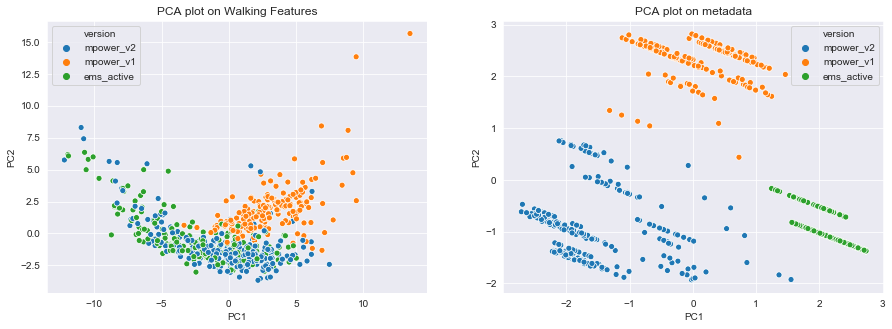

In [87]:
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "version")